In [ ]:
from repath.experiments.tissuedet import *

set_seed(global_seed)
detection_level = 5
final_level = 7
morphology_transform1 = MaxPoolTransform(level_in=detection_level, level_out=final_level)
morphology_transform2 = SizedClosingTransform(level_in=final_level)
morphology_transform3 = FillHolesTransform(level_in=final_level)
morphology_transforms = [morphology_transform1, morphology_transform2, morphology_transform3]
tissue_detector_test = TissueDetectorGreyScale(grey_level=0.85, morph_transform = morphology_transforms)
calc_tissue_conf_mat(tissue_detector_test, "greyscale_maxpool", final_level, experiment_root)
get_output_images(tissue_detector_test, "greyscale_maxpool", final_level, experiment_root)
write_contours_to_file(tissue_detector_test, "greyscale_maxpool", final_level, experiment_root, level_out=0)

In [ ]:
# path = project_root() / 'experiments' / 'tissue' / 'greyscale' / 'outline_output_images' / 'IC-CX-00001-01.jpg'
path = project_root() / 'experiments' / 'tissue' / 'greyscale_fill_holes' / 'greyscale_fill_holes_confidence_matrix.png'

from PIL import Image
Image.open(path)

In [ ]:
from repath.preprocess.tissue_detection import TissueDetectorGreyScale, SimpleClosingTransform, NullTransform, SizedClosingTransform, FillHolesTransform

level_in=7

morph_transform1 = SizedClosingTransform(level_in=level_in)
morph_transform2 = FillHolesTransform(level_in=level_in)
morph_transforms = [morph_transform1, morph_transform2]

from repath.preprocess.tissue_detection import MedianBlur, GaussianBlur

pre_transform1 = MedianBlur(filter_size=2)
pre_transform2 = GaussianBlur(sigma=2)
pre_transforms = [pre_transform1, pre_transform2]

tissue_detector_test = TissueDetectorGreyScale(grey_level=0.85, morph_transform=morph_transforms)

In [ ]:
from repath.experiments.tissuedet import *
from repath.utils.export import convert_mask_to_json
from repath.preprocess.tissue_detection.tissue_metrics import get_slide_output_masks, create_colour_output, create_overlay_output
from repath.utils.geometry import Size

level_in = 5
datset = tissue.tissue()
for idx, path in enumerate(datset.paths.slide[7:8]):
    print(path)
    annot_path = datset.paths.annotation.iloc[idx]
    test_path = project_root() / datset.root / path
    truth_path = project_root() / datset.root / annot_path
    with datset.slide_cls(test_path) as slide:
        thumb = slide.get_thumbnail(level_in)
        tissue_mask_detected = tissue_detector(thumb)
        if level_in >= len(slide.dimensions):
            request_level = len(slide.dimensions) - 1
            lev_diff = level_in - request_level
            max_level_dim = slide.dimensions[-1]
            requested_level_size = Size(max_level_dim.width // 2 ** lev_diff, max_level_dim.height // 2 ** lev_diff)
            labels_shape = requested_level_size.as_shape()
        else:
            labels_shape = slide.dimensions[level_in].as_shape()
        tissue_annotations = datset.load_annotations(truth_path)
        scale_factor = 2 ** level_in
        tissue_mask_annotated = tissue_annotations.render(labels_shape, scale_factor)
        tn_arr, fp_arr, fn_arr, tp_arr = get_slide_output_masks(tissue_mask_annotated, tissue_mask_detected)
        colour_thumb = create_colour_output(tn_arr, fp_arr, fn_arr, tp_arr)
        #outline_thumb = create_overlay_output(thumb, tissue_mask_detected)

In [ ]:
Image.fromarray(np.array(tissue_mask_detected*255, dtype=np.uint8))

In [ ]:
import cv2

blank_im = np.zeros(tissue_mask_detected.shape, dtype=np.uint8)
contours, hierarchy = cv2.findContours(np.array(tissue_mask_detected, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contour_im = cv2.drawContours(blank_im, contours, -1, [255,255,255], 20)
Image.fromarray(np.array(contour_im, dtype=np.uint8))

In [ ]:
np.sum(contour_im > 0)

In [ ]:
import cv2

level_in=7
level_out=7

# convert to PIL image
im_out = Image.fromarray(np.array(tissue_mask_detected*255, dtype=np.uint8))

# calculate new image size
level_diff = level_in - level_out
size_diff = 2 ** level_diff
new_size = (im_out.size[0] * size_diff, im_out.size[1] * size_diff)

# resize image
im_resize = im_out.resize(new_size, Image.BOX)

contours, hierarchy = cv2.findContours(np.array(tissue_mask_detected, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


In [ ]:
has_parent = [ct > -1 for ct in hierarchy[0, :, 3]]
hierarchy[0, has_parent, :]

In [ ]:
has_child = [ct > -1 for ct in hierarchy[0, :, 2]]
hierarchy[0, has_child, :]

In [ ]:
no_parent_no_child = np.logical_and(np.logical_not(has_parent), np.logical_not(has_child))
np.sum(no_parent_no_child)

In [ ]:
parent_no_child = np.logical_and(has_parent, np.logical_not(has_child))
np.sum(parent_no_child)

In [ ]:
child_no_parent = np.logical_and(np.logical_not(has_parent), has_child)
np.sum(child_no_parent)

In [ ]:
parent_and_child = np.logical_and(has_parent, has_child)
np.sum(parent_and_child)

In [ ]:
hierarchy[0, parent_and_child, :]

In [ ]:
parent_and_child_list = np.arange(len(contours))[parent_and_child]
grandkids_mask = np.isin(hierarchy[0, :, 3], parent_and_child_list)


In [ ]:
np.sum(np.logical_and(grandkids_mask, parent_no_child))

In [ ]:
no_parent_no_child_list = np.arange(len(contours))[no_parent_no_child]
grandkids_list = np.arange(len(contours))[grandkids_mask]
parents_list = np.arange(len(contours))[child_no_parent]
top_level_list = np.hstack((no_parent_no_child_list, grandkids_list, parents_list))


In [ ]:
json_points = []

for ct in top_level_list:
    child_mask = hierarchy[0, :, 3] == ct
    got_kids = np.sum(child_mask) > 0
    if got_kids:
        polygon1 = contours[ct]
        pts = []
        for pt in range(polygon1.shape[0]):
            pnt = polygon1[pt][0].tolist()
            pts.append(pnt)
        json_polygon = [pts]
        kids = np.array(contours, dtype=object)[np.arange(len(contours))[child_mask]]
        for kid in kids:
            pts = []
            for pt in range(kid.shape[0]):
                pnt = kid[pt][0].tolist()
                pts.append(pnt)
            json_polygon.append(pts)
        json_points.append(json_polygon)
    else:
        pts = []
        for pt in range(contours[ct].shape[0]):
            pnt = contours[ct][pt][0].tolist()
            pts.append(pnt)
        json_points.append([pts])

In [ ]:
npolys = [len(jp) for jp in json_points]
np.array(npolys)[np.array(npolys) > 1]

In [ ]:
len(npolys)

In [ ]:
cnt

# Get tissue not tissue patches for game

In [ ]:
import cv2

def patches_for_game(tissue_detector_test: TissueDetector, label: str, level_in: int, base_dir: Path) -> None:
    """
    For a tissue detector this gets tissue no tissue patches for gamification app
    
    Args:
            tissue_detector_test (TissueDetector): A class of tissue detector to test
            label (str): A label to add to filenames for naming output of this experiment
            level_in (int): The level at which to carry out the tissue detection
            best_dir (path): directory to write out data

    """
    tissue_dataset = tissue.tissue()
    psize = 2 ** level_in
    patch_finder = GridPatchFinder(labels_level=level_in, patch_level=0, patch_size=psize, stride=psize, remove_background=False)

    # create blank slides with just tissue detector labels
    tissue_patchsets_detected = SlidesIndex.index_dataset(tissue_dataset, tissue_detector_test, patch_finder, notblank=False)

    # find patches close to edges
    tissue_patchsets_edges = find_patches_close_to_edge(tissue_dataset, tissue_patchsets_detected, tissue_detector_test)

    # combine into one
    tissue_patches_edges = CombinedIndex.for_slide_indexes([tissue_patchsets_edges])

    # filter to get only edge patches
    tissue_patches_edges.patches_df = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.edge_patch == True]

    # get sample of tissue_patches
    tissue_patches_sample = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.label == 1]
    tissue_patches_sample = tissue_patches_sample.sample(n=1000, axis=0)

    # get sample of non tissue_patches
    non_tissue_patches_sample = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.label == 0]
    non_tissue_patches_sample = non_tissue_patches_sample.sample(n=1000, axis=0)

    # combine into one set
    combined_sample = pd.concat((tissue_patches_sample, non_tissue_patches_sample), axis=0)
    tissue_patches_edges.patches_df = combined_sample

    # save patches
    tissue_patches_edges.save_patches(output_dir=Path(project_root(),"experiments","tissue","patches_for_game"))



In [ ]:
def find_patches_close_to_edge(datset, slides_index, tissue_detector):

    for sps in slides_index:
        path = datset.paths.slide[sps.slide_idx]
        test_path = test_path = project_root() / datset.root / path
        with datset.slide_cls(test_path) as slide:
            thumb = slide.get_thumbnail(level_in)
        tissue_mask_detected = tissue_detector(thumb)
        # find patches close to the contours of the image
        blank_im = np.zeros(tissue_mask_detected.shape, dtype=np.uint8)
        contours, hierarchy = cv2.findContours(np.array(tissue_mask_detected, dtype=np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour_im = cv2.drawContours(blank_im, contours, -1, [255,255,255], 20)
        contour_im = contour_im > 0
        df = to_frame_with_locations(contour_im, "edge_patch")
        col_nams = sps.patches_df.columns.tolist()
        col_nams.append("edge_patch")
        patches_df = pd.concat((sps.patches_df, df.iloc[:, 2:3]), axis=1, ignore_index=True)
        patches_df.columns = col_nams
        sps.patches_df = patches_df
        
    return slides_index

In [ ]:
tissue_dataset = tissue.tissue()
psize = 2 ** level_in
patch_finder = GridPatchFinder(labels_level=level_in, patch_level=0, patch_size=psize, stride=psize, remove_background=False)

# create blank slides with just tissue detector labels
tissue_patchsets_detected = SlidesIndex.index_dataset(tissue_dataset, tissue_detector_test, patch_finder, notblank=False)

# find patches close to edges
tissue_patchsets_edges = find_patches_close_to_edge(tissue_dataset, tissue_patchsets_detected, tissue_detector_test)

# combine into one
tissue_patches_edges = CombinedIndex.for_slide_indexes([tissue_patchsets_edges])

# filter to get only edge patches
tissue_patches_edges.patches_df = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.edge_patch == True]

# get sample of tissue_patches
tissue_patches_sample = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.label == 1]
tissue_patches_sample = tissue_patches_sample.sample(n=1000, axis=0)

# get sample of non tissue_patches
non_tissue_patches_sample = tissue_patches_edges.patches_df[tissue_patches_edges.patches_df.label == 0]
non_tissue_patches_sample = non_tissue_patches_sample.sample(n=1000, axis=0)

# combine into one set
combined_sample = pd.concat((tissue_patches_sample, non_tissue_patches_sample), axis=0)
tissue_patches_edges.patches_df = combined_sample

# save patches
tissue_patches_edges.save_patches(output_dir=Path(project_root(),"experiments","tissue","patches_for_game"))

In [ ]:
path = project_root() / 'experiments' / 'tissue' / 'patches_for_game' / 'background' / 'images-IC-EN-02079-01.isy-40064-18048.png'

from PIL import Image
Image.open(path)

In [ ]:
path = project_root() / 'experiments' / 'tissue' / 'patches_for_game' / 'tissue' / 'images-IC-EN-02092-01.isy-58880-19712.png'

from PIL import Image
Image.open(path)

In [ ]:
basepath = project_root() / 'experiments' / 'lee' / 'post_hnm_results' / 'patch_summaries' / 'valid16' 
path = basepath / 'patch_pr_curve_ci.png'

from PIL import Image
Image.open(path)

In [ ]:
path = basepath / 'confidence_matrix.png'

from PIL import Image
Image.open(path)

In [ ]:
basepath = project_root() / 'experiments' / 'wang' / 'post_hnm_results' / 'patch_summaries' / 'valid16' 
path = basepath / 'patch_pr_curve_ci.png'

from PIL import Image
Image.open(path)

In [ ]:
path = basepath / 'confidence_matrix.png'

from PIL import Image
Image.open(path)

In [ ]:
basepath = project_root() / 'experiments' / 'wang' / 'pre_hnm_results' / 'patch_summaries' / 'valid16' 
path = basepath / 'patch_pr_curve_ci.png'

from PIL import Image
Image.open(path)

In [ ]:
path = basepath / 'confidence_matrix.png'

from PIL import Image
Image.open(path)

In [ ]:
basepath = project_root() / 'experiments' / 'liu' / 'inference_results' /  'valid16mean' / 'patch_summaries' / 'confidence_matrix.png'
Image.open(basepath)

In [ ]:
basepath = project_root() / 'experiments' / 'liu' / 'inference_results' /  'valid16mean' / 'patch_summaries' / 'patch_pr_curve.png'
Image.open(basepath)

In [ ]:
basepath = project_root() / 'experiments' / 'wang' / 'pre_hnm_results' / 'valid16' / 'results' / 'tumor' / 'tumor_003.csv'

import pandas as pd
df = pd.read_csv(basepath)
df['col'] = df['x'].divide(256)
df['row'] = df['y'].divide(256)
df

In [ ]:
blank_image = np.zeros((int(np.max(df.row)+1), int(np.max(df.col)+1)))
Image.fromarray(np.array(blank_image,dtype=np.uint8))

In [ ]:
for rr in range(df.shape[0]):
    rw = df.iloc[rr, :]
    blank_image[int(rw.row), int(rw.col)] = 255
    
Image.fromarray(np.array(blank_image,dtype=np.uint8))

In [ ]:
impath = project_root() / 'data' / 'camelyon16' / 'raw' / 'training' / 'tumor' / 'tumor_003.tif'

In [ ]:
from repath.data.slides.openslide import Slide

with Slide(impath) as slide:
    thumb = slide.get_thumbnail(8)
    
Image.fromarray(np.array(thumb, dtype=np.uint8))

In [138]:
normpath = project_root() / 'experiments' / 'wang' /'training_patches' / 'normal'
tumpath = project_root() / 'experiments' / 'liu' /'training_patches' / 'tumor'


In [116]:
import os

normlist = os.listdir(normpath)
tumlist = os.listdir(tumpath)

,x,y,label,transform
0,89984,96,1,1
1,90016,96,1,1
2,90048,96,1,1
3,90080,96,1,1
4,90112,96,1,1
...,...,...,...,...
383977,5632,218208,1,1
383978,5664,218208,1,1
383979,5696,218208,1,1
383980,5728,218208,1,1


In [117]:
from PIL import Image
im = 0

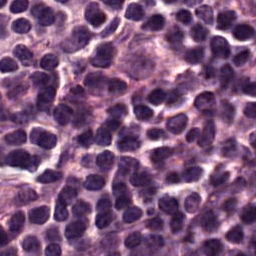

In [148]:
im +=1000
Image.open(normpath / normlist[im])

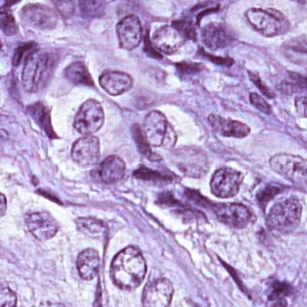

In [145]:
Image.open(tumpath / tumlist[im])

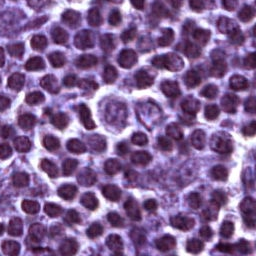

In [143]:
tst2 = Image.open(normpath / normlist[im])
import cv2
import numpy as np

tst2 = cv2.cvtColor(np.array(tst2), cv2.COLOR_BGR2RGB)

Image.fromarray(np.array(tst2, dtype=np.uint8))

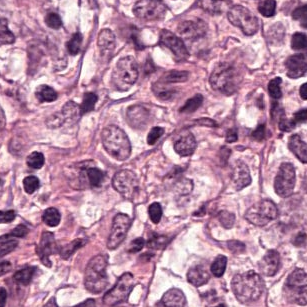

In [140]:
tst = Image.open(tumpath / tumlist[im])
import cv2
import numpy as np

tst = cv2.cvtColor(np.array(tst), cv2.COLOR_BGR2RGB)

Image.fromarray(np.array(tst, dtype=np.uint8))

In [133]:
from repath.utils.paths import project_root
import pandas as pd

normpath = project_root() / 'experiments' / 'wang' / 'train_samples' / 'combined_index.csv'

normcsv = pd.read_csv(normpath)
normcsv

,x,y,label,transform,slide_idx,cps_idx
0,18144,38528,1,1,227,0
1,74432,154880,1,1,174,0
2,71360,137024,1,1,60,0
3,27520,60224,1,1,77,0
4,73504,87200,1,1,249,0
...,...,...,...,...,...,...
3999995,40160,87552,2,1,53,0
3999996,38048,136416,2,1,60,0
3999997,23520,157216,2,1,25,0
3999998,16640,37760,2,1,75,0


In [134]:
normcsv_small = normcsv.iloc[0:10, :]

In [76]:
import repath.data.datasets.camelyon16 as camelyon16

cam16 = [camelyon16.training()]
cam16[0][201]

(PosixPath('/home/ubuntu/repath/data/camelyon16/raw/training/normal/normal_092.tif'),
 '',
 'normal',
 '')

In [77]:
psize = [256]
levs = [0]

In [78]:
for cps_idx, cps_group in normcsv_small.groupby('cps_idx'):
    for slide_idx, sl_group in cps_group.groupby('slide_idx'):
        slide_path, _, _, _ = cam16[cps_idx][slide_idx]
        print(slide_path)
        with cam16[cps_idx].slide_cls(slide_path) as slide:
            print(f"Writing patches for {cam16[cps_idx].to_rel_path(slide_path)}")
            for row in sl_group.itertuples():
                print(row)
                print(slide.dimensions)
                # read the patch image from the slide
                region = Region.patch(row.x, row.y, psize[cps_idx], levs[cps_idx])
                image = slide.read_region(region)

                # apply any transforms, as indexed in the 'transform' column
                if transforms:
                    image = transforms[row.transform-1](image)  # TODO: row.transforms should be 0 indexed by is 1 indexed

                # get the patch label as a string
                labels = {v: k for k, v in cam16[cps_idx].labels.items()}
                label = labels[row.label]

                # ensure the output directory exists
                #output_subdir = output_dir / label
                #output_subdir.mkdir(parents=True, exist_ok=True)

                # write out the slide
                rel_slide_path = cam16[cps_idx].to_rel_path(slide_path)
                slide_name_str = str(rel_slide_path)[:-4].replace('/', '-')
                #patch_filename = slide_name_str + f"-{row.x}-{row.y}{affix}.png"
                # image_path = output_dir / label / patch_filename
                # cv2.imwrite(str(image_path), np.array(image))
                # image.save(image_path)
                


/home/ubuntu/repath/data/camelyon16/raw/training/normal/normal_032.tif
Writing patches for normal/normal_032.tif
Pandas(Index=3, x=27424, y=157888, label=1, transform=1, slide_idx=142, cps_idx=0)
[Size(width=97792, height=221184), Size(width=48896, height=110592), Size(width=24448, height=55296), Size(width=12224, height=27648), Size(width=6112, height=13824), Size(width=3056, height=6912), Size(width=1528, height=3456), Size(width=764, height=1728), Size(width=382, height=864), Size(width=191, height=432)]
Pandas(Index=9, x=64928, y=138464, label=1, transform=1, slide_idx=142, cps_idx=0)
[Size(width=97792, height=221184), Size(width=48896, height=110592), Size(width=24448, height=55296), Size(width=12224, height=27648), Size(width=6112, height=13824), Size(width=3056, height=6912), Size(width=1528, height=3456), Size(width=764, height=1728), Size(width=382, height=864), Size(width=191, height=432)]
/home/ubuntu/repath/data/camelyon16/raw/training/normal/normal_091.tif
Writing patches 

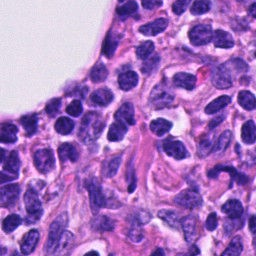

In [63]:
image

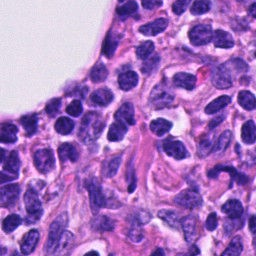

In [79]:
image

In [152]:
import random

random.sample(range(1777), 43)

[1187,
 823,
 53,
 1561,
 1287,
 415,
 1307,
 1184,
 1057,
 722,
 673,
 1073,
 877,
 632,
 428,
 272,
 617,
 320,
 952,
 905,
 1528,
 921,
 1678,
 1111,
 1017,
 1089,
 945,
 1257,
 1555,
 1674,
 898,
 732,
 1086,
 187,
 164,
 322,
 1732,
 1189,
 1028,
 1267,
 1044,
 1214,
 1336]